In [1]:
# !pip install econml lightgbm pandas scikit-learn matplotlib seaborn rpy2 dowhy

### Heterogeneous Treatment Effects:

Another advantage of Causal ML is to estimate Heterogenous Treatment Effect, i.e. individual effect of treatment. 

In [4]:
# Load imports

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from econml.dml import LinearDML, CausalForestDML
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import lightgbm as lgb 
import dowhy
import dowhy.datasets

# Set a consistent style for plots
sns.set_style("whitegrid")
plt.style.use('seaborn-v0_8-whitegrid')

---

### 1. The Dataset: The Lalonde NSW Program

We'll be using the **National Supported Work (NSW) dataset**, famously analyzed by Robert Lalonde.

The data evaluates the effectiveness of a job training program from the 1970s. The core question is: **Did the program causally increase participants' earnings after they completed it?**

The key variables are:

* **Treatment (`treat`)**: A binary variable. `1` if the person participated in the job training program, `0` otherwise.
* **Outcome (`re78`)**: The person's real earnings in 1978, after the program was completed.
* **Confounders**: A set of pre-treatment characteristics that might influence both participation in the program and future earnings, such as:
    * `age`, `educ` (years of education)
    * `black`, `hisp` (race indicators)
    * `married` (marital status)
    * `nodegree` (indicator for no high school degree)
    * `re74`, `re75` (real earnings in 1974 and 1975, before the program)

Let's load the data and take a look.

In [5]:
df = dowhy.datasets.lalonde_dataset()
print("\nDataset Information:")
df.info()

df

KeyboardInterrupt: 

In [4]:
# Define the outcome, treatment, and covariates
outcome = 're78'      # Real earnings in 1978 (outcome)
treatment = 'treat'   # 1 if in the program, 0 otherwise (treatment)
covariates = [col for col in df.columns if col not in [outcome, treatment]]

# Separate our variables for clarity
Y = df[outcome]
T = df[treatment]
X = df[covariates]

print("Data loaded successfully.")
print(f"Dataset shape: {df.shape}")
print(f"Number of treated units: {df[treatment].sum()}")
print(f"Number of control units: {len(df) - df[treatment].sum()}\n")

Data loaded successfully.
Dataset shape: (445, 12)
Number of treated units: 185
Number of control units: 260



In [ ]:
# Define the outcome, treatment, and covariates
outcome = 're78'      # Real earnings in 1978 (outcome)
treatment = 'treat'   # 1 if in the program, 0 otherwise (treatment)

# Covariates are all other variables
covariates = [col for col in df.columns if col not in [outcome, treatment]]

# Separate our variables for clarity
Y = df[outcome]
T = df[treatment]
X = df[covariates]

### Step 3.2: Uncovering Heterogeneous Effects with CausalForestDML

To investigate the heterogenous effects of the policy, we now move from the *average* effect to **heterogeneous effects**. Our goal is to estimate the **Conditional Average Treatment Effect (CATE)**, which measures the causal effect for specific subgroups of the population based on their characteristics.

The next cell will use `CausalForestDML`, a powerful model designed specifically to uncover these personalized effects and answer the crucial question: **For whom does this program work best?**

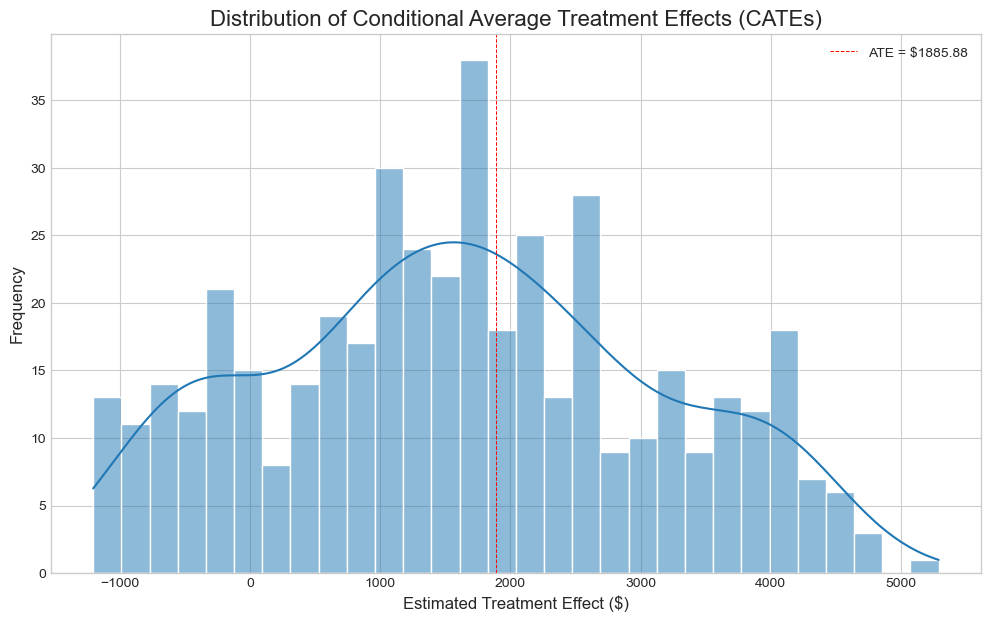

In [25]:
# 1. Initialize the CausalForestDML estimator
# We use the same nuisance models as before.
est_forest = CausalForestDML(
    model_y=RandomForestRegressor(n_estimators=100, min_samples_leaf=10, random_state=42),
    model_t=RandomForestClassifier(n_estimators=100, min_samples_leaf=10, random_state=42),
    discrete_treatment=True,
    random_state=42
)

# 2. Fit the estimator to the data
est_forest.fit(Y, T, X=X)

# 3. Get the Conditional Average Treatment Effects (CATEs)
# The .effect() method gives a personalized treatment effect for each individual in X.
cate_estimates = est_forest.effect(X)

# 4. Visualize the distribution of CATEs
plt.figure(figsize=(12, 7))
sns.histplot(cate_estimates, kde=True, bins=30)
plt.title('Distribution of Conditional Average Treatment Effects (CATEs)', fontsize=16)
plt.xlabel('Estimated Treatment Effect ($)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Add a vertical line for the ATE from the LinearDML model for comparison
# Note: Use the ATE value you calculated in the previous step
ate_value = ate_summary.mean_point
plt.axvline(ate_value, color='red', linestyle='--', linewidth=0.7, label=f'ATE = ${ate_value:.2f}')

plt.legend()
plt.grid(True)
plt.show()